# FAISS Vector Store Pipeline für PDF-Dokumente

In [4]:
import os
import fitz  # PyMuPDF
import faiss
import numpy as np
import umap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter


/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === 1. PDF-Text extrahieren ===

In [5]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

pdf_paths = [
    "data/Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf",
    "data/Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf",
    "data/ZHAW_Zitierleitfaden_DE.pdf",
    "data/02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf",
    "data/05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf",
    "data/Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf",
    "data/Schwerpunktthemen_fuer_Studenten.pdf",
    "data/W_MB_Merkblatt_Bachelorarbeit_BSc.pdf",
    "data/Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf"
]

texts = [extract_text_from_pdf(path) for path in pdf_paths]

# === 2. Texte in Chunks aufteilen ===

In [6]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = splitter.create_documents(texts)

# === 3. Embeddings generieren ===

In [7]:
model = SentenceTransformer("Sahajtomar/German-semantic")
texts_for_embedding = [doc.page_content for doc in documents]
embeddings = model.encode(texts_for_embedding, show_progress_bar=True)

Batches: 100%|██████████| 8/8 [06:18<00:00, 47.26s/it]


# === 4. FAISS Index erstellen ===

In [8]:
dimension = embeddings[0].shape[0]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

# === 5. UMAP-Projektion ===

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


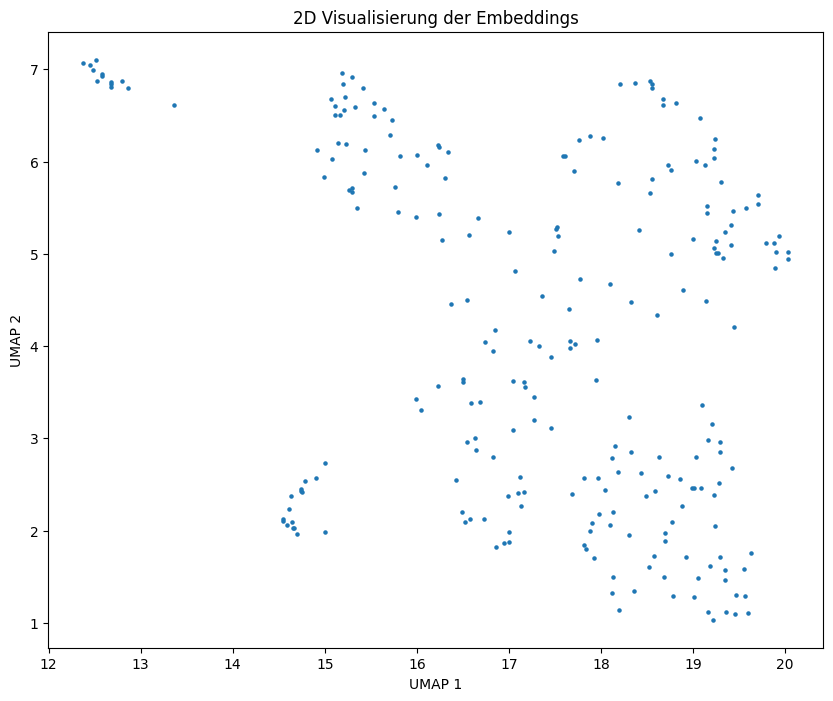

In [9]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding_2d = umap_model.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=5)
plt.title("2D Visualisierung der Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

# === 6. Semantische Suche ===

In [10]:
def semantic_search(query, top_k=3):
    query_embedding = model.encode([query])
    distances, indices = index.search(np.array(query_embedding), k=top_k)
    return [documents[i].page_content for i in indices[0]]

# === 7. Prompt Konstruktion für Groq LLM ===

In [19]:
def build_prompt(context, question):
    return f"""
Verwenden Sie den folgenden Kontext, um die Frage zu beantworten.

Kontext:
{context}

Frage:
{question}

Antwort:
"""

# === 8. Anfrage an Groq LLM API ===

In [23]:
def query_groq_llm(prompt, api_key):
    url = "https://api.groq.com/openai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "llama-3.3-70b-versatile",
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.7
    }
    response = requests.post(url, headers=headers, json=data)
    return response.json()['choices'][0]['message']['content']

# === 9. Beispielanfrage ===

In [28]:
import requests

if __name__ == "__main__":
    user_query = "What is the most important factor in diagnosing asthma?"
    retrieved_chunks = semantic_search(user_query, top_k=3)
    context_block = "\n---\n".join(retrieved_chunks)
    prompt = build_prompt(context_block, user_query)

    GROQ_API_KEY = "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"
    
    if GROQ_API_KEY:
        answer = query_groq_llm(prompt, GROQ_API_KEY)
        print("Final answer from the LLM:\n")
        print(answer)
    else:
        print("[Error] GROQ_API_KEY environment variable not set.")



Final answer from the LLM:

Leider enthält der bereitgestellte Kontext keine Informationen über die Diagnose von Asthma oder relevante Faktoren, die bei der Diagnose berücksichtigt werden sollten. Der Kontext befasst sich hauptsächlich mit Zitierleitfäden, Bildungsmanagement und ein paar spezifischen Quellen zu verschiedenen Themen, einschließlich Raucherentwöhnung und Bildung. Es gibt keine direkte Verbindung zu Asthma oder medizinischen Diagnoseverfahren.

Um eine genaue Antwort auf Ihre Frage zu geben, bräuchte ich spezifische Informationen oder Studien zum Thema Asthma-Diagnose. Ohne diese Informationen kann ich keine fundierte Antwort liefern. Wenn Sie weitere Informationen oder Kontext haben, stehe ich Ihnen gerne zur Verfügung, um Ihre Frage zu beantworten.
